<a href="https://colab.research.google.com/github/DanHerman212/vertex-ai-ml-pipelines-time-series/blob/main/training_and_preprocessing_workflows/ml_dataset_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing Workflows for ML Training

This notebook outlines the comprehensive data preprocessing pipeline required to prepare subway arrival data for deep learning models.

**Workflow Overview:**
1.  **Data Loading**: Fetching raw data from Google Cloud Storage.
2.  **Data Cleaning**: Handling missing values and removing outliers (negative durations, extreme delays).
3.  **Exploratory Data Analysis (EDA)**: Visualizing time series slices, heatmaps, and distributions to understand data characteristics.
4.  **Spectral Analysis**: Using NUFFT (Non-Uniform Fast Fourier Transform) to identify dominant periodicities (daily, weekly).
5.  **Feature Engineering**:
    *   **Cyclical Features**: Encoding time of day and day of week using Sine/Cosine transformations.
    *   **Weather Integration**: Merging external weather data (temperature, precipitation, etc.) to provide environmental context.
    *   **Rolling Regime Features**: Calculating rolling means and standard deviations to capture short-term trends and volatility.
6.  **Export**: Saving the fully processed dataset for model training.

<a id="setup"></a>
# Environment Setup & Configuration

In [1]:
from google.cloud import storage # For accessing GCS buckets
import os # For environment variable management
import numpy as np # For numerical operations
import pandas as pd # For data manipulation
import matplotlib.pyplot as plt # For plotting
import plot_timeseries as viz # Custom module for specialized time series visualizations

import warnings
warnings.filterwarnings('ignore')


In [5]:
# set plot figure size
plt.rcParams["figure.figsize"] = (9,6)

<a id="loading"></a>
# Data Loading
The file `dec18dataset.csv` contains the ml dataset that is ready to be preprocessed in this workflow.

In [6]:
df = pd.read_csv('dec19dataset.csv')

df.head()

,arrival_date,duration,mbt,dow
0,2024-01-01 00:34:05 UTC,24.02,NaN,0
1,2024-01-01 00:49:29 UTC,26.87,15.40,0
2,2024-01-01 01:02:10 UTC,28.02,12.68,0
3,2024-01-01 01:17:55 UTC,31.92,15.75,0
4,2024-01-01 01:34:17 UTC,31.03,16.37,0


In [4]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109917 entries, 0 to 109916
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   arrival_date  109917 non-null  datetime64[ns, UTC]
 1   dow           109917 non-null  int64              
 2   duration      109917 non-null  float64            
 3   mbt           109916 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1)
memory usage: 3.4 MB


### There are a small number of nulls, we will just remove them as we have a sufficiently dense sampling of arrival times over a 2 year period

In [15]:
# Remove null values
initial_len = len(df)
df = df.dropna()
print(f"Dropped {initial_len - len(df)} rows containing null values.")

Dropped 1 rows containing null values.


<a id="cleaning"></a>
# Data Cleaning & Outlier Removal

### Outlier Analysis & Cleaning

We will perform the following steps:
1. **Remove Bad Data (Duration)**: Filter out rows with negative `duration` values.
2. **Remove Extreme Outliers (Duration)**: Filter out rows where `duration > 55` minutes. A duration > 55 mins implies a massive delay (e.g., 20+ mins in a tunnel), which is considered an error or non-representative event.
3. **Remove Extreme Outliers (MBT)**: Filter out rows where `mbt > 35` minutes. These represent ~4% of the data and are considered errors or non-useful extreme events.
4. **Analyze Distributions**: Inspect the cleaned data to decide on further transformations (e.g., Log Transform).

In [5]:
# duration
# 1. Remove Bad Data: Filter out negative duration instances
initial_count = len(df)
df = df[df['duration'] >= 0].copy()
print(f"Removed {initial_count - len(df)} rows with negative duration.")

# 2. Remove Extreme Outliers: Filter out duration > 150 minutes
# there are 30 instances of duration between 100 - 150 minutes from 2024 - 2025
upper_duration_bound = 55
initial_count = len(df)
df = df[df['duration'] <= upper_duration_bound].copy()
print(f"Removed {initial_count - len(df)} rows where duration > {upper_duration_bound} mins.")

# 3. Analyze distribution of outliers for duration
print("\n--- Duration Distribution (Outliers) ---")
# Display quantiles to see the spread, including extremes
print(df['duration'].quantile([0.0, 0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999, 1.0]))

Removed 17 rows with negative duration.
Removed 1546 rows where duration > 55 mins.

--- Duration Distribution (Outliers) ---
0.000     0.13
0.001    16.08
0.010    22.90
0.050    23.92
0.250    25.67
0.500    27.33
0.750    30.50
0.950    44.08
0.990    51.53
0.999    54.58
1.000    55.00
Name: duration, dtype: float64


In [6]:
# 3. Remove Extreme Outliers: Filter out mbt > 35 minutes
# User identified that > 35 mins is likely error/garbage data (approx 4% of data)
upper_bound = 35
initial_count = len(df)
df = df[df['mbt'] <= upper_bound].copy()
print(f"Removed {initial_count - len(df)} rows where mbt > {upper_bound} mins.")

Removed 438 rows where mbt > 35 mins.


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
dow,108354.0,0.189472,0.391885,0.00,0.00,0.00,0.00,1.00
duration,108354.0,29.464092,6.228327,0.13,25.67,27.33,30.50,55.00
mbt,108353.0,9.027384,37.070398,0.00,4.38,6.85,10.75,4775.58


In [7]:
df.head()

,arrival_date,dow,duration,mbt
0,2024-01-01 00:34:05+00:00,0,24.02,NaN
1,2024-01-01 00:49:29+00:00,0,26.87,15.40
2,2024-01-01 01:02:10+00:00,0,28.02,12.68
3,2024-01-01 01:17:55+00:00,0,31.92,15.75
4,2024-01-01 01:34:17+00:00,0,31.03,16.37


<a id="eda"></a>
# Exploratory Data Analysis (EDA)

## 1. Visualizing Time Series Slices
First, we zoom in on a small slice of the data (first 175 points) to inspect the "texture" of the time series. This helps us verify that the data looks like a valid sequence of subway arrivals and allows us to spot any immediate irregularities or patterns at a granular level.

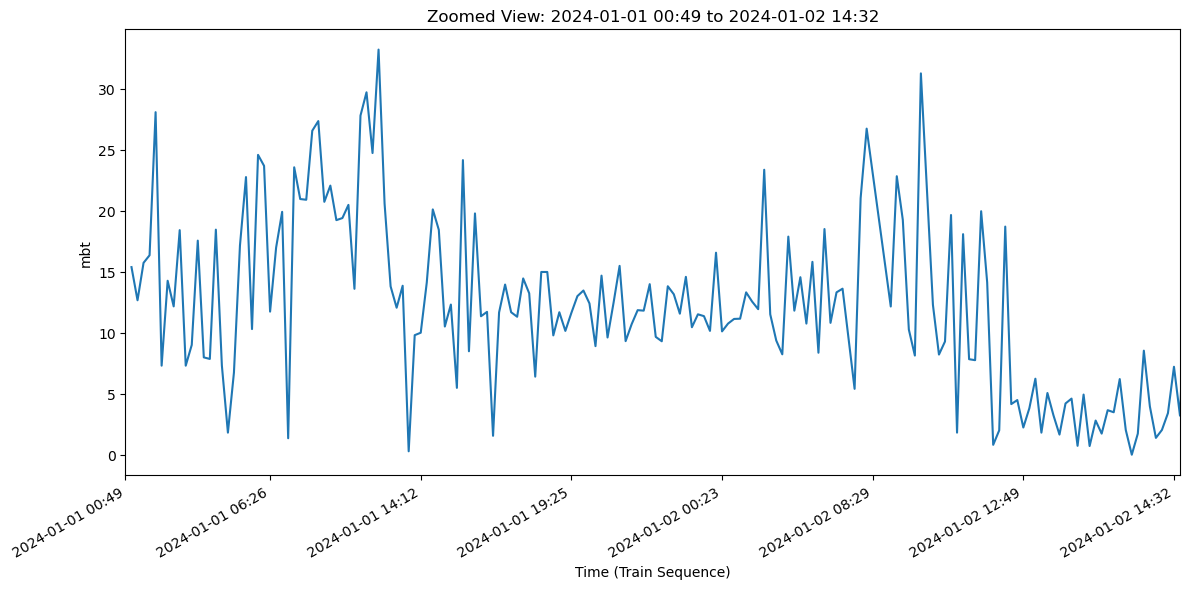

In [7]:
# sort the dates
#df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

viz.plot_zoomed_slice(df, 'mbt', start_idx=0, end_idx=175)

This plot shows roughly 36 hours or 1.5 days of data, capturing the typical ebb and flow of subway arrivals over a short period.

# The Heatmap (The "Fingerprint" of Transit)
This is the gold standard for transit data. It visualizes the schedule density by Time of Day vs. Day of Week. It will immediately reveal rush hours and weekend schedules.

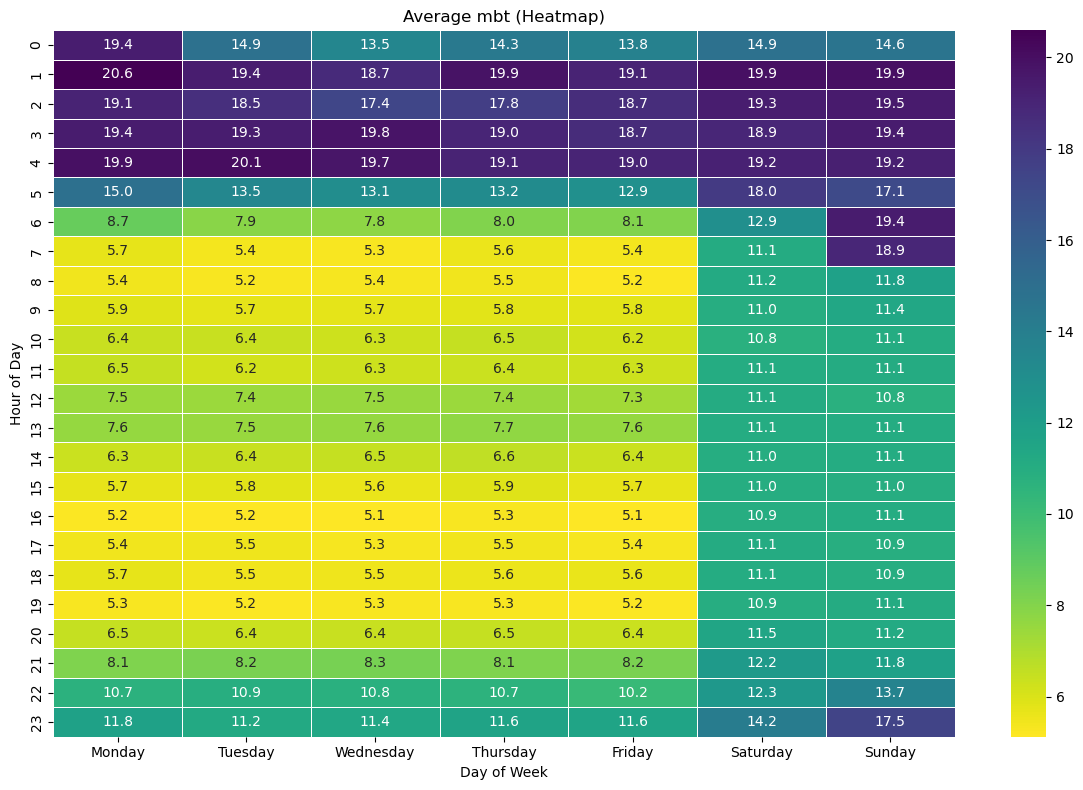

In [12]:
viz.plot_heatmap(df, 'mbt')

The heatmap clearly shows the weekday rush hour peaks in the morning and evening, as well as the reduced service on weekends. This "fingerprint" confirms that the dataset accurately reflects typical subway operations.

## 3. Distribution Analysis
Understanding the distribution of our target variable (`mbt`) is crucial. We expect a right-skewed distribution (most trains arrive frequently, with a long tail of delays). This plot helps us confirm that assumption and identify the range of "normal" operations versus outlier delays.

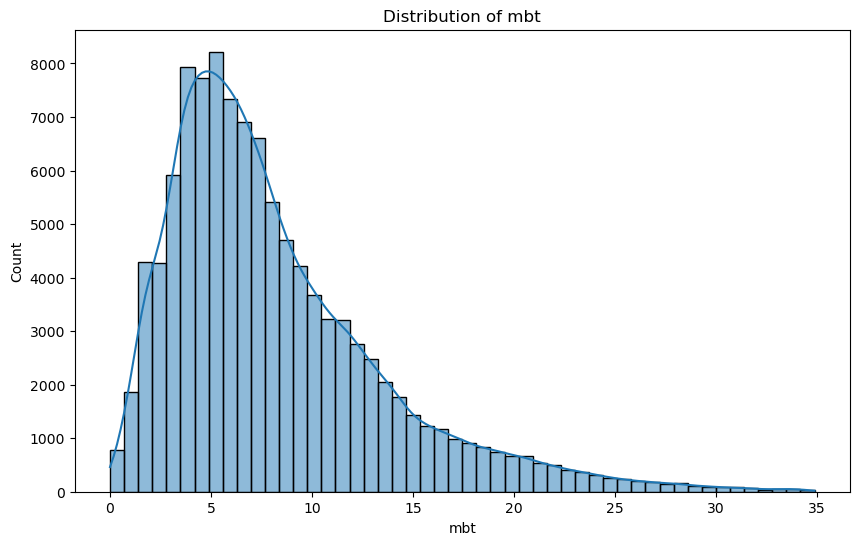

In [13]:
viz.plot_distribution(df, 'mbt')

The distribution shows a clear right skew, with most `mbt` values clustered around lower durations and a long tail extending towards higher delays. This confirms our expectation of frequent arrivals with occasional significant delays.

<a id="nufft"></a>
# Spectral Analysis (NUFFT)
### Preprocessing using NUFFT (Non-Uniform Fast Fourier Transform)
To better understand the periodic patterns in our transit data, we will apply the Non-Uniform Fast Fourier Transform (NUFFT). This technique is particularly useful for analyzing time series data that may not be uniformly sampled, such as transit arrival times.

In [9]:
from scipy.signal import lombscargle
import numpy as np
import matplotlib.pyplot as plt

### Lomb-Scargle Periodogram
We use the **Lomb-Scargle** method because our data might have gaps (irregular sampling). Unlike standard FFT which requires evenly spaced data, Lomb-Scargle is designed to find periodic signals in unevenly sampled time series.

We will look for peaks at:
*   **1/day**: Daily cycles (Rush hour patterns)
*   **1/week**: Weekly cycles (Weekday vs Weekend schedules)

Dropped 1 NaN rows for spectral analysis.


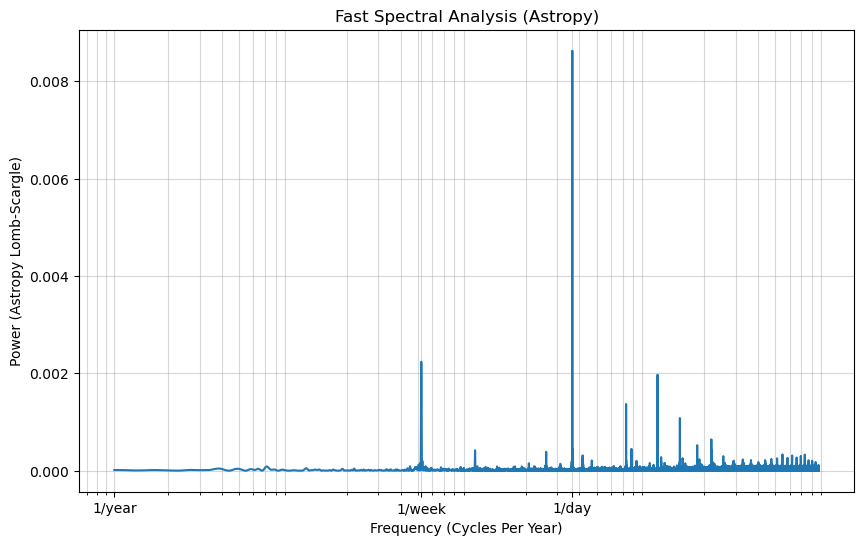

In [12]:
from astropy.timeseries import LombScargle

# prepare data
if 'arrival_date' not in df.columns:
    print("Error: 'date' column required.")
else:
    # Create a clean subset for spectral analysis
    # Lomb-Scargle cannot handle NaNs, so we drop them here
    spectral_df = df[['arrival_date', 'mbt']].dropna()
    
    if len(spectral_df) < len(df):
        print(f"Dropped {len(df) - len(spectral_df)} NaN rows for spectral analysis.")

    # convert to days for astropy 
    t_days = (spectral_df['arrival_date'] - spectral_df['arrival_date'].min()).dt.total_seconds().values / (24 * 3600)
    y_signal = spectral_df['mbt'].values

    # compute periodogram (autoselects best frequencies)
    # autopower automatically determines the frequency grid and uses the fft method
    frequency, power = LombScargle(t_days, y_signal).autopower(minimum_frequency=1/365.25, maximum_frequency=24)

    # plot
    plt.figure(figsize=(10, 6))

    # convert frequency (cycles/day) to cycles/year for readability
    freq_per_year = frequency * 365.25

    plt.plot(freq_per_year, power)
    plt.xscale('log')

    # mark key periodicities
    plt.xticks([1, 52, 365.25], ['1/year', '1/week', '1/day'])

    plt.xlabel('Frequency (Cycles Per Year)')
    plt.ylabel('Power (Astropy Lomb-Scargle)')
    plt.title('Fast Spectral Analysis (Astropy)')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

The periodogram reveals strong peaks at both daily and weekly frequencies, confirming the expected periodic patterns in subway arrivals. This insight will guide our feature engineering process.

<a id="features"></a>
# Feature Engineering
Our spectral analysis confirmed strong periodicities at 1 day and 1 week, we should explicitly encode these cycles into our dataset.  Specifically, we will convert time features into cyclical features using sine and cosine transformations.<br>
<br>
Machine learning models (like LSTMs) struggle with raw time inputs (e.g., Hour 0 and Hour 23 look "far apart" numerically, but they are actually adjacent). The standard fix is to transform time into Cyclical Features using Sine and Cosine waves.<br>
<br>

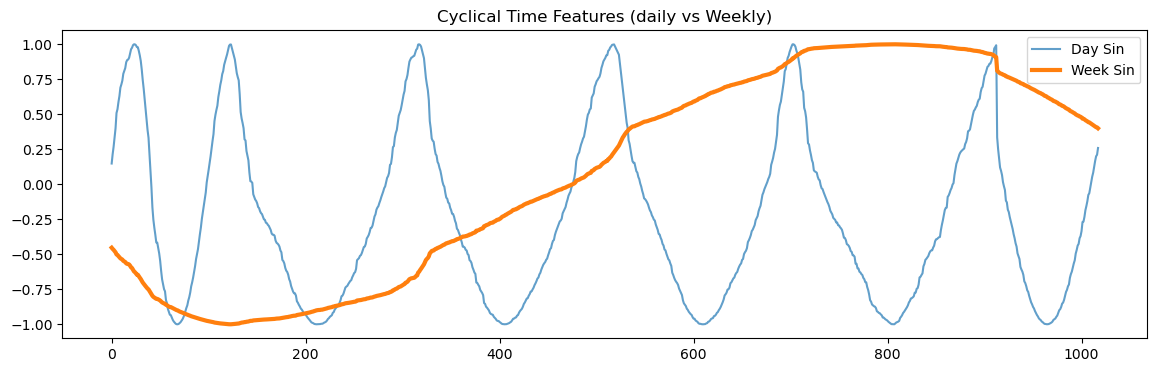

In [11]:
# convert timestamp to seconds to calculate precise angles
timestamp_s = df['arrival_date'].map(pd.Timestamp.timestamp)

# define periods in seconds
day = 24 * 60 * 60
week = 7 * day
year = (365.2425) * day

# 1. encode daily seasonality (captures rush hour vs. evening)
df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

# 2. encode weekly seasonality (captures weekday vs.weekend)
df['week_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['week_cos'] = np.cos(timestamp_s * (2 * np.pi / week))

# --- NEW: Rolling Regime Features ---
# These features explicitly tell the model the "current speed" of the system.
# This helps the LSTM adjust its expectations for the next step based on recent history
# visualize to verify, zoom in on a few days
plt.figure(figsize=(14, 4))
# plotting first 1000 points (approx 1 week of data)
plt.plot(df['day_sin'][:1000], label='Day Sin', alpha=0.7)
plt.plot(df['week_sin'][:1000], label='Week Sin', linewidth=3)
plt.title("Cyclical Time Features (daily vs Weekly)")
plt.legend(loc='upper right')
plt.show()

Cyclical features for:
*   Time of Day (capturing daily cycles)
*   Day of Week (capturing weekly cycles)

# Weather Data Integration

Weather data is integrated into the ML pipeline to provide additional context for train arrival predictions. By merging weather features (such as temperature, precipitation, snow, visibility and wind speed) with the main dataset, the model can account for external factors that may influence train delays or arrival times. 
<br><br>
This integration is done by the hour, connecting hourly weather data to the closest arrival timestamp.  This procedure ensuring that each train event is enriched with the relevant weather conditions at that time and place. 

In [14]:
# --- WEATHER DATA INTEGRATION (REWRITTEN) ---

# 1. Load the weather data
weather_df = pd.read_csv('../weather_data.csv') 

# 2. Select only the physics-based features
weather_features = ['datetime', 'temp', 'precip', 'snow', 'snowdepth', 'visibility', 'windspeed']
weather_df = weather_df[weather_features].copy()

# 3. Convert weather timestamp to datetime objects
# FIX: Ensure UTC to avoid timezone mismatch errors during merge
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], utc=True)

# 4. FIX: Align Date Ranges
# Since weather data starts in 2024, we must drop older train data to avoid NaNs.
print(f"Original Train Count: {len(df)}")
df = df[df['arrival_date'] >= '2024-01-01'].copy()
print(f"Filtered Train Count (2024+): {len(df)}")

# 5. Create a "Join Key" in your Train Data
# Round train arrival time to the nearest hour to match weather data
# FIX: Ensure UTC for the join key
df['weather_join_key'] = pd.to_datetime(df['arrival_date'], utc=True).dt.round('h')

# 6. Merge
# Left join ensures we keep all train trips
df = pd.merge(df, weather_df, left_on='weather_join_key', right_on='datetime', how='left')

# 7. Clean up
# Forward fill missing weather data (small gaps)
weather_cols = ['temp', 'precip', 'snow', 'snowdepth', 'visibility', 'windspeed']
df[weather_cols] = df[weather_cols].fillna(method='ffill')

# Drop the helper columns (join key and the duplicate weather timestamp)
df.drop(columns=['weather_join_key', 'datetime'], inplace=True)

print("Merge Complete. New Shape:", df.shape)
display(df.head())

Original Train Count: 107916
Filtered Train Count (2024+): 107916
Merge Complete. New Shape: (107926, 10)


,arrival_date,dow,duration,mbt,temp,precip,snow,snowdepth,visibility,windspeed
0,2024-01-01 00:49:29+00:00,0,26.87,15.40,42.2,0.0,0.0,0.0,9.9,6.9
1,2024-01-01 01:02:10+00:00,0,28.02,12.68,42.2,0.0,0.0,0.0,9.9,6.9
2,2024-01-01 01:17:55+00:00,0,31.92,15.75,42.2,0.0,0.0,0.0,9.9,6.9
3,2024-01-01 01:34:17+00:00,0,31.03,16.37,42.2,0.0,0.0,0.0,9.9,5.0
4,2024-01-01 02:02:23+00:00,0,42.05,28.10,42.2,0.0,0.0,0.0,9.9,5.0


array([[<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'precip'}>],
       [<Axes: title={'center': 'snow'}>,
        <Axes: title={'center': 'snowdepth'}>],
       [<Axes: title={'center': 'visibility'}>,
        <Axes: title={'center': 'windspeed'}>]], dtype=object)

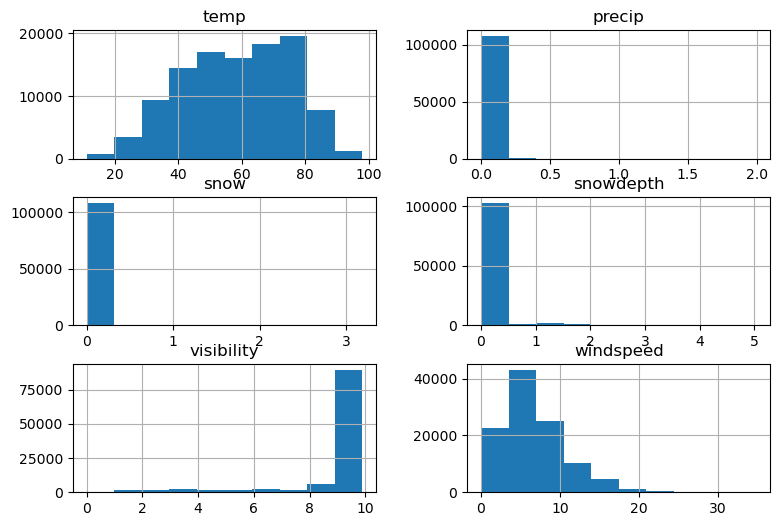

In [15]:
df.iloc[:, 4:].hist()

### Weather Data Distributions
The histograms above visualize the distributions of the integrated weather features:

*   **temp**: Shows a broad distribution roughly between 20 and 90 (likely Fahrenheit), reflecting the seasonal variation over the dataset.
*   **precip, snow, snowdepth**: These are heavily right-skewed (zero-inflated). This is expected, as most hours have clear weather (no precipitation or snow accumulation).
*   **visibility**: Heavily left-skewed, with the vast majority of data points at the maximum value (likely 10 miles). This indicates that visibility is generally good, with occasional drops due to weather events.
*   **windspeed**: Right-skewed distribution, with typical wind speeds clustering between 5-15 and occasional high-wind events.

This confirms that the weather data has been correctly merged and reflects realistic meteorological patterns.

# Rolling Regime Features and Their Purpose

Rolling regime features are engineered to capture the recent behavioral patterns of the train system over a moving time window. These features typically include rolling averages, standard deviations, and other statistics calculated over a fixed number of previous time steps (e.g., the last 5 or 10 arrivals). <br><br>
The purpose of these regime features is to provide the model with information about short-term trends, volatility, and anomalies in train arrivals, which may not be evident from static features alone. 

In [13]:
# --- REAPPLY ROLLING REGIME FEATURES AFTER WEATHER MERGE ---

# These features should be recalculated after merging weather data, to ensure alignment with the final dataset.
 # 1. Rolling Features
# Calculate rolling std with window 50
df['rolling_std_50'] = df['mbt'].rolling(window=50).std().bfill()
# Add Rolling Max to capture recent spikes (delays)
df['rolling_max_10'] = df['mbt'].rolling(window=10).max().bfill()
# Add Rolling Mean/Std 10 (mentioned in prompt text of NHITS notebook)
df['rolling_mean_10'] = df['mbt'].rolling(window=10).mean().bfill()
df['rolling_std_10'] = df['mbt'].rolling(window=10).std().bfill()
df['rolling_mean_50'] = df['mbt'].rolling(window=50).mean().bfill()

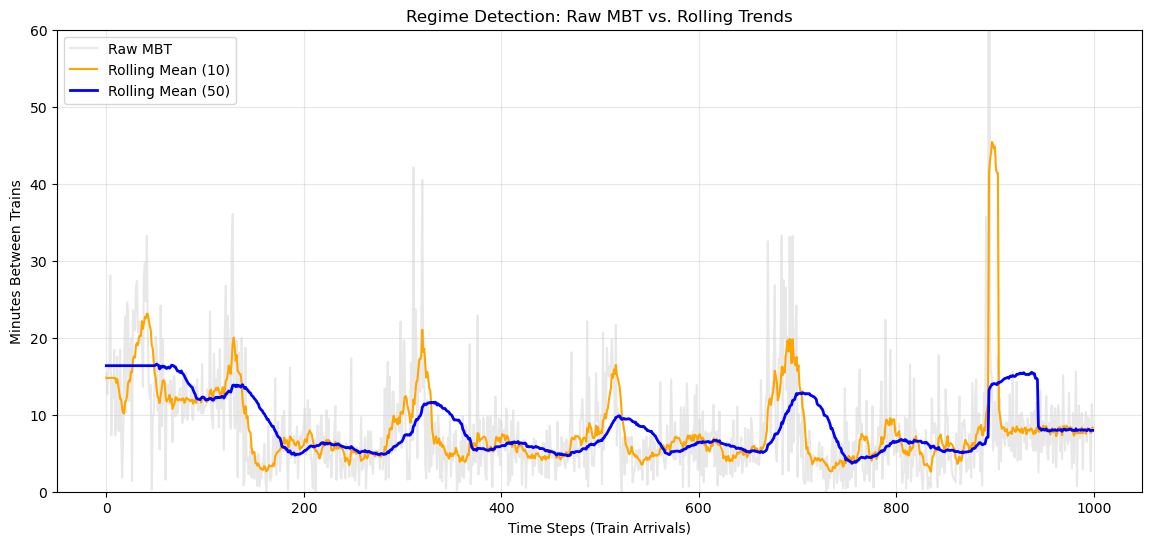

In [17]:
# visualize to verify, zoom in on a few days
plt.figure(figsize=(14, 6))

# Slice the first 1000 points (approx 1 week)
slice_idx = 1000
x_axis = range(slice_idx)

# 1. Plot Raw MBT (The noisy signal)
plt.plot(x_axis, df['mbt'][:slice_idx], label='Raw MBT', color='lightgray', alpha=0.5)

# 2. Plot Short-Term Trend (Window 10)
plt.plot(x_axis, df['rolling_mean_10'][:slice_idx], label='Rolling Mean (10)', color='orange', linewidth=1.5)

# 3. Plot Long-Term Trend (Window 50)
plt.plot(x_axis, df['rolling_mean_50'][:slice_idx], label='Rolling Mean (50)', color='blue', linewidth=2)

plt.title("Regime Detection: Raw MBT vs. Rolling Trends")
plt.ylabel("Minutes Between Trains")
plt.xlabel("Time Steps (Train Arrivals)")
plt.legend()
plt.grid(True, alpha=0.3)

# Set y-axis limit to focus on the main trend, ignoring extreme spikes
plt.ylim(0, 60)

plt.show()

### Interpreting the Regime Detection Plot
This visualization demonstrates how the rolling features help the model "see" the underlying state of the transit system amidst the noise:

*   **Raw MBT (Gray)**: The actual minutes between trains. It is highly volatile and "spiky," making it difficult for a model to predict the next exact value based solely on the previous one.
*   **Rolling Mean 10 (Orange)**: This captures **short-term trends**. It reacts quickly to delays but smooths out single-point anomalies. When this line spikes, it indicates a cluster of delayed trains.
*   **Rolling Mean 50 (Blue)**: This captures the **long-term regime**. It represents the "sustained" service level (e.g., the difference between 5-minute rush hour service and 15-minute late-night service).

**Key Insight for the Model**:
By providing both the raw data and these smoothed "regime" features, we allow the model to differentiate between a **random outlier** (where the gray line spikes but the blue line stays flat) and a **systemic breakdown** (where both lines rise together).

In [18]:
df.head()

,arrival_date,dow,duration,mbt,temp,precip,snow,snowdepth,visibility,windspeed,rolling_std_50,rolling_max_10,rolling_mean_10,rolling_std_10,rolling_mean_50
0,2024-01-01 00:49:29+00:00,0,26.87,15.40,42.2,0.0,0.0,0.0,9.9,6.9,7.643376,28.1,14.783,5.937839,16.3698
1,2024-01-01 01:02:10+00:00,0,28.02,12.68,42.2,0.0,0.0,0.0,9.9,6.9,7.643376,28.1,14.783,5.937839,16.3698
2,2024-01-01 01:17:55+00:00,0,31.92,15.75,42.2,0.0,0.0,0.0,9.9,6.9,7.643376,28.1,14.783,5.937839,16.3698
3,2024-01-01 01:34:17+00:00,0,31.03,16.37,42.2,0.0,0.0,0.0,9.9,5.0,7.643376,28.1,14.783,5.937839,16.3698
4,2024-01-01 02:02:23+00:00,0,42.05,28.10,42.2,0.0,0.0,0.0,9.9,5.0,7.643376,28.1,14.783,5.937839,16.3698


<a id="save"></a>
# Save Processed Dataset
Finally, we save the fully processed and enriched dataset to a CSV file. This file (`full_clean_ml_datset.csv`) will be the input for our training workflows (N-HiTS, LSTM, GRU).

In [19]:
# save dataset to ml_training_workflows

df.to_csv('../training_and_preprocessing_workflows/full_clean_ml_datset.csv', header=True, index=False)